In [1]:
import pandas as pd
import model as m
import pymc3 as pm
import model_helper as mh
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns_c = sns.color_palette(palette='deep')

In [2]:
ccaa = "AR"

start_date = pd.to_datetime('2020-07-01')
end_date = pd.to_datetime('2020-12-01')

# Cases
cases = pd.read_csv("data/casos_tecnica_ccaa.csv")
cases = cases.loc[cases["ccaa_iso"] == ccaa]
cases["fecha"] = pd.to_datetime(cases["fecha"])
cases.set_index("fecha", inplace=True)
cases = cases["num_casos"]
cases_train = cases.loc[start_date:end_date]

# Occupancy
occupancy = pd.read_csv("data/aragon.csv")
occupancy.index= pd.to_datetime(occupancy["date"],format="%Y-%m-%d")
occupancy = occupancy.sort_index().asfreq('D')
occupancy = occupancy.interpolate()["hospitalized"]
occupancy_train = occupancy.loc[start_date:end_date]

# Probabilities
pH = np.loadtxt(f"results/pH_admission_{ccaa}.txt").mean()
admissions_beta = np.loadtxt(f"results/beta_admission_{ccaa}.txt").mean()

In [3]:
# Run model
draws = 5000
burn = 2000
with m.occupancy_model(cases_train, occupancy_train, pH, admissions_beta) as model:
    trace = pm.sample(draws, tune=burn)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
/tmp/ipykernel_37174/3799698953.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws, tune=burn)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, discharge_sigma, discharge_mu]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 103 seconds.


In [4]:
import arviz as az
az.summary(trace,hdi_prob=.95)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/aleta/Desktop/test/COVID_hospitalization/venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
discharge_mu,2.473,0.018,2.439,2.509,0.000,0.000,7359.0,7546.0,1.0
discharge_sigma,0.624,0.034,0.561,0.692,0.000,0.000,7460.0,7746.0,1.0
sigma,42.629,2.546,37.855,47.789,0.027,0.019,8764.0,6797.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
/home/aleta/Desktop/test/COVID_hospitalization/venv/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'discharge_mu'}>,
        <AxesSubplot:title={'center':'discharge_mu'}>],
       [<AxesSubplot:title={'center':'discharge_sigma'}>,
        <AxesSubplot:title={'center':'discharge_sigma'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

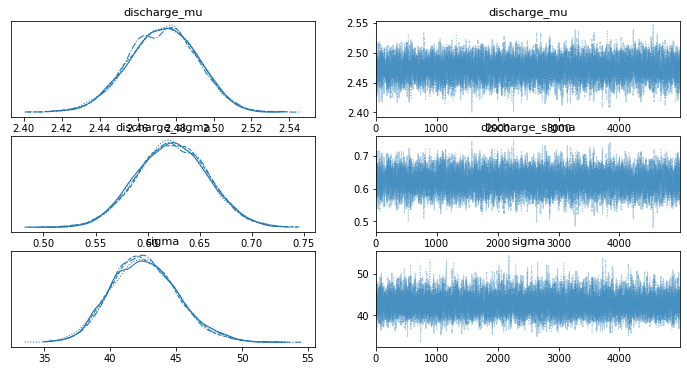

In [5]:
az.plot_trace(trace)

In [6]:
with model:
    hospitalization = pm.sample_posterior_predictive(trace,10000)

/home/aleta/Desktop/test/COVID_hospitalization/venv/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


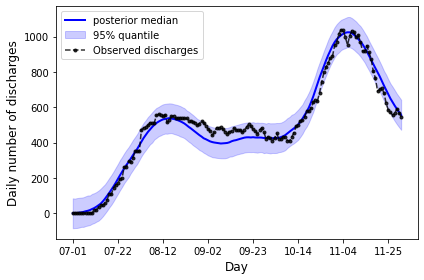

In [7]:
dates = pd.date_range(start_date, end_date).strftime("%m-%d")
plot_dates = [dates[i] for i in range(0, len(occupancy_train), 21)]

posterior_quantile = np.percentile(hospitalization["occupancy"], [2.5, 25, 50, 75, 97.5], axis=0)

# Plot daily number of admissions
plt.plot(
    dates, posterior_quantile[2, :],
    color='b', label='posterior median', lw=2)

plt.fill_between(
    dates, posterior_quantile[0, :], posterior_quantile[4, :],
    color='b', label='95% quantile', alpha=.2)

plt.plot(
      dates, occupancy_train,
      '--o', color='k', markersize=3,
      label='Observed discharges', alpha=.8)

plt.xticks(plot_dates)
plt.ylabel('Daily number of discharges', fontsize='large')
plt.xlabel('Day', fontsize='large')

fontsize = 'medium'
plt.legend(loc='upper left', fontsize=fontsize)

plt.tight_layout();

In [8]:
end_date = pd.to_datetime('2021-07-12')
cases_test = cases.loc[start_date:end_date]
occupancy_test = occupancy.loc[start_date:end_date]

with m.occupancy_model(cases_test, np.empty(cases_test.shape), pH, admissions_beta) as predictive_model:
    prediction = pm.sample_posterior_predictive(trace, samples=5000)

/home/aleta/Desktop/test/COVID_hospitalization/venv/lib/python3.8/site-packages/pymc3/model.py:1755: ImputationWarning: Data in occupancy contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/home/aleta/Desktop/test/COVID_hospitalization/venv/lib/python3.8/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


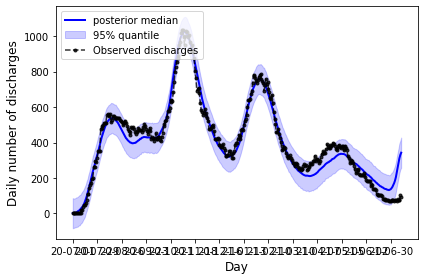

In [9]:
dates = pd.date_range(start_date, end_date).strftime("%y-%m-%d")
plot_dates = [dates[i] for i in range(0, len(occupancy_test), 28)]

posterior_quantile = np.percentile(prediction["occupancy"], [2.5, 25, 50, 75, 97.5], axis=0)

# Plot daily number of admissions
plt.plot(
    dates, posterior_quantile[2, :],
    color='b', label='posterior median', lw=2)

plt.fill_between(
    dates, posterior_quantile[0, :], posterior_quantile[4, :],
    color='b', label='95% quantile', alpha=.2)

plt.plot(
      dates, occupancy_test,
      '--o', color='k', markersize=3,
      label='Observed discharges', alpha=.8)

plt.xticks(plot_dates)
plt.ylabel('Daily number of discharges', fontsize='large')
plt.xlabel('Day', fontsize='large')

fontsize = 'medium'
plt.legend(loc='upper left', fontsize=fontsize)

plt.tight_layout();

# Output

In [10]:
np.savetxt(f"results/mu_discharge_{ccaa}.txt", trace["discharge_mu", :])
np.savetxt(f"results/sigma_discharge_{ccaa}.txt", trace["discharge_sigma", :])
np.savetxt(f"results/sigma_occupancy_{ccaa}.txt", trace["sigma", :])

data = {"median" : posterior_quantile[2, :],
        "lower" : posterior_quantile[0, :],
        "upper" : posterior_quantile[4, :],
        "observed" : occupancy_test
       }

pd.DataFrame.from_dict(data).to_csv(f"results/values_occupancy_{ccaa}.csv")